# Computer Vision Parking Lot Occupancy

## 2. Calling the CV model on a single image

We made an object detection model with customvision.ai in order to detect cars from an image.
1. Open https://www.customvision.ai/
2. Create an object detection project
3. Import the images from the zip file you made with the previous notebook
4. Tag earch car for each training image
5. Build and train the object detection model
6. Deploy the model

We can call now the model we made.

<img src="cv1.jpg">

<img src="cv2.jpg">

## Settings

In [1]:
import sys
import matplotlib.pyplot as plt
import cv2
import time
import datetime
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials

In [2]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [3]:
now = datetime.datetime.today().strftime ('%d-%b-%Y %H-%M-%S')
print(now)

31-Jan-2022 14-20-44


## Testing

In [4]:
myimage = "image/test1.jpg"

width:   1100
height:  720
channel: 3


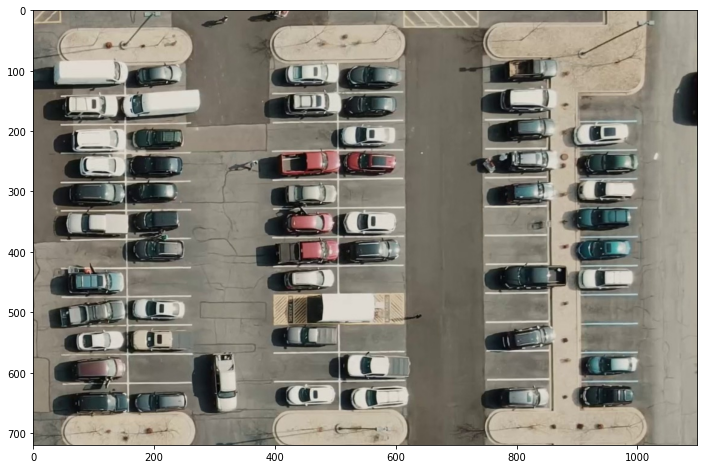

In [5]:
image = cv2.imread(myimage)
h, w, c = image.shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)  

plt.figure(figsize=(18, 8))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

## Calling the CV model

In [6]:
PREDICTION_KEY = "tobecompleted"
ENDPOINT = "tobecompleted"
PROJECT_ID = "tobecompleted"
ITERATION_NAME = "tobecompleted"

In [7]:
credentials = ApiKeyCredentials(in_headers={"Prediction-key": PREDICTION_KEY })
predictor = CustomVisionPredictionClient(ENDPOINT, credentials)

In [8]:
# Parking zones coordinates
zone1_x1 = 43
zone1_x2 = 263
zone1_y1 = zone2_y1 = zone3_y1 = 82
zone1_y2 = zone2_y2 = zone3_y2 = 674
zone2_x1 = 388
zone2_x2 = 617
zone3_x1 = 744
zone3_x2 = 1000

In [9]:
print("Calling CV model...\n")

color_lime = (0, 255, 0)
color_cyan = (255, 255, 0)
color_red = (0, 0, 255)
color_orange = (0, 140, 255)

with open(myimage, mode="rb") as captured_image:
    results = predictor.detect_image(PROJECT_ID, ITERATION_NAME, captured_image)
    resultoutputfile = "image/result.jpg" # output file

# Init
i=1
nb_vehicles_zone1 = nb_vehicles_zone2 = nb_vehicles_zone3 = nb_vehicles_NA = 0
location_vehicle = ''

now = str(datetime.datetime.today().strftime ('%d-%b-%Y %H:%M:%S'))
msg_now = '[CCTV 1] ' + str(now)
cv2.putText(image, msg_now, (30, 20), cv2.FONT_HERSHEY_PLAIN, 1.1, color_lime, 2, cv2.LINE_AA)

# Zone displays
result_image = cv2.rectangle(image, (zone1_x1, zone1_y1), (zone1_x2, zone1_y2), color_orange, 4)
result_image = cv2.putText(image, "Area 1", (zone1_x1, zone1_y1-10), cv2.FONT_HERSHEY_PLAIN, 
                           1.5, color_cyan, 2, cv2.LINE_AA)

result_image = cv2.rectangle(image, (zone2_x1, zone2_y1), (zone2_x2, zone2_y2), color_orange, 4)
result_image = cv2.putText(image, "Area 2", (zone2_x1, zone1_y1-10), cv2.FONT_HERSHEY_PLAIN, 
                           1.5, color_cyan, 2, cv2.LINE_AA)
        
result_image = cv2.rectangle(image, (zone3_x1, zone3_y1), (zone3_x2, zone3_y2), color_orange, 4)
result_image = cv2.putText(image, "Area 3", (zone3_x1, zone1_y1-10), cv2.FONT_HERSHEY_PLAIN, 
                           1.5, color_cyan, 2, cv2.LINE_AA)

for prediction in results.predictions:
    
    if prediction.probability >= 0.8:
        # Printing
        print(i, '\tDetected object =', str.upper(prediction.tag_name), 'with confidence =', 
              round(prediction.probability, 5))
        
        # Vehicles only
        if prediction.tag_name == 'Vehicle':  
            bbox = prediction.bounding_box
            
            # Average coordinates of each vehicles
            x_center = int((bbox.width * w) / 2 + (bbox.left  * w))
            y_center = int((bbox.height * h) / 2 + (bbox.top * h))
            
            # Drawing ROI for each vehicles
            result_image = cv2.rectangle(image, 
                                         (int(bbox.left * w), int(bbox.top * h)), 
                                         (int((bbox.left + bbox.width) * w), int((bbox.top + bbox.height) * h)), 
                                         color_lime, 3)
            
            # Testing if vehicles belong to a zone
            if x_center >= zone1_x1 and x_center <= zone1_x2:
                    location_vehicle = "zone1"
                    nb_vehicles_zone1 += 1
                    result_image = cv2.rectangle(image, 
                                         (int(bbox.left * w), int(bbox.top * h)), 
                                         (int((bbox.left + bbox.width) * w), int((bbox.top + bbox.height) * h)), 
                                         color_red, 3)
            
            if x_center >= zone2_x1 and x_center <= zone2_x2:
                    location_vehicle = "zone2"
                    nb_vehicles_zone2 += 1
                    result_image = cv2.rectangle(image, 
                                         (int(bbox.left * w), int(bbox.top * h)), 
                                         (int((bbox.left + bbox.width) * w), int((bbox.top + bbox.height) * h)), 
                                         color_red, 3)
            
            if x_center >= zone3_x1 and x_center <= zone3_x2:
                    location_vehicle = "zone3"
                    nb_vehicles_zone3 += 1
                    result_image = cv2.rectangle(image, 
                                         (int(bbox.left * w), int(bbox.top * h)), 
                                         (int((bbox.left + bbox.width) * w), int((bbox.top + bbox.height) * h)), 
                                         color_red, 3)
            
            if (x_center < zone1_x1) or (x_center > zone1_x2 and x_center < zone2_x1)\
            or (x_center > zone2_x2 and x_center <zone3_x1) or (x_center > zone3_x2):
                location_vehicle = 'Entering/Leaving'
                cv2.putText(result_image, location_vehicle, (x_center + 25, y_center), cv2.FONT_HERSHEY_PLAIN, 
                            2, color_lime, 2, cv2.LINE_AA)
                nb_vehicles_NA += 1
                result_image = cv2.circle(image, (x_center, y_center), radius=5, color=color_lime, thickness=4)
                result_image = cv2.circle(image, (x_center, y_center), radius=10, color=color_red, thickness=4)
            
            i+=1

nb_vehicles = i - 1

# Display message on the image
msg_nb_vehicules = 'Number of vehicles = ' + str(nb_vehicles)
cv2.putText(result_image, msg_nb_vehicules, (30, 50), cv2.FONT_HERSHEY_PLAIN, 2, color_lime, 2, cv2.LINE_AA)

print('\033[1;31;34m')
print("\nThere are", nb_vehicles, 'detected vehicles in the image')

totalplaces_zone1 = 24
totalplaces_zone2 = 22
totalplaces_zone3 = 23
totalvehicles_in_zones = nb_vehicles_zone1 + nb_vehicles_zone2 + nb_vehicles_zone3
totalplaces = totalplaces_zone1 + totalplaces_zone2 + totalplaces_zone3
freeplaces = totalplaces - totalvehicles_in_zones
pct_freeplaces = round((totalplaces - nb_vehicles) / totalplaces * 100)

msgfree = 'Free parking spaces available =' + str(freeplaces)
cv2.putText(result_image, msgfree, (500, 50), cv2.FONT_HERSHEY_PLAIN, 2, color_lime, 2, cv2.LINE_AA)

msgfree1 = "Free = " + str(totalplaces_zone1 - nb_vehicles_zone1)
msgfree2 = "Free = " + str(totalplaces_zone2 - nb_vehicles_zone2)
msgfree3 = "Free = " + str(totalplaces_zone3 - nb_vehicles_zone3)

cv2.putText(result_image, msgfree1, (zone1_x1 + 100, zone1_y1 - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, 
            color_cyan, 2, cv2.LINE_AA)
cv2.putText(result_image, msgfree2, (zone2_x1 + 100, zone1_y1 - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, 
            color_cyan, 2, cv2.LINE_AA)
cv2.putText(result_image, msgfree3, (zone3_x1 + 100, zone1_y1 - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, 
            color_cyan, 2, cv2.LINE_AA)

cv2.imwrite(resultoutputfile, result_image, [int(cv2.IMWRITE_JPEG_QUALITY), 100] )

free_zone1 = totalplaces_zone1 - nb_vehicles_zone1
free_zone2 = totalplaces_zone2 - nb_vehicles_zone2
free_zone3 = totalplaces_zone3 - nb_vehicles_zone3
nb_parked_vehicles = nb_vehicles - nb_vehicles_NA

print("\033[1;31;34m\nParking spaces available =", freeplaces, '(', pct_freeplaces, '% )')
print("\nNumber of parked vehicles =", nb_parked_vehicles)
print("Number of vehicles in zone 1 =", nb_vehicles_zone1, "| Free parking spaces available =", free_zone1)
print("Number of vehicles in zone 2 =", nb_vehicles_zone2, "| Free parking spaces available =", free_zone2)
print("Number of vehicles in zone 3 =", nb_vehicles_zone3, "| Free parking spaces available =", free_zone3)
print("\nNumber of vehicules who are entering/leaving = ", nb_vehicles_NA)


Calling CV model...

1 	Detected object = VEHICLE with confidence = 0.99995
2 	Detected object = VEHICLE with confidence = 0.99994
3 	Detected object = VEHICLE with confidence = 0.99993
4 	Detected object = VEHICLE with confidence = 0.99992
5 	Detected object = VEHICLE with confidence = 0.99991
6 	Detected object = VEHICLE with confidence = 0.99991
7 	Detected object = VEHICLE with confidence = 0.99991
8 	Detected object = VEHICLE with confidence = 0.9999
9 	Detected object = VEHICLE with confidence = 0.99989
10 	Detected object = VEHICLE with confidence = 0.99988
11 	Detected object = VEHICLE with confidence = 0.99988
12 	Detected object = VEHICLE with confidence = 0.99988
13 	Detected object = VEHICLE with confidence = 0.99988
14 	Detected object = VEHICLE with confidence = 0.99985
15 	Detected object = VEHICLE with confidence = 0.99985
16 	Detected object = VEHICLE with confidence = 0.99985
17 	Detected object = VEHICLE with confidence = 0.99983
18 	Detected object = VEHICLE with co

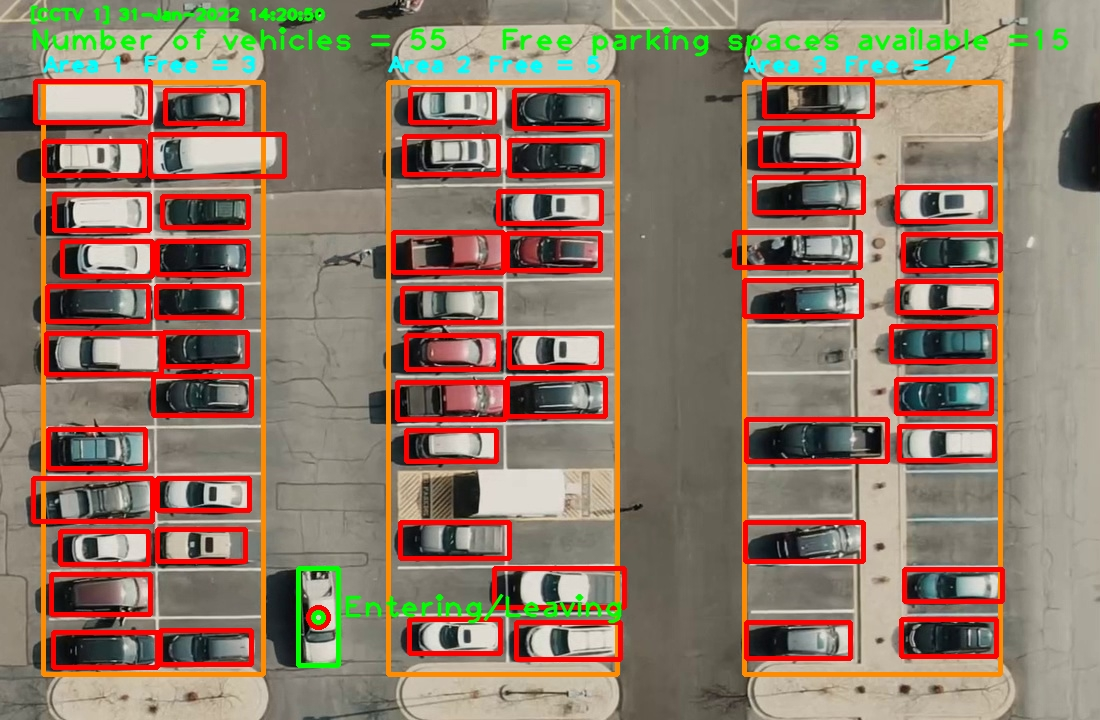

In [10]:
from IPython.display import Image
sample_image = 'image/result.jpg'
Image(filename=sample_image) 